In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy
import gensim
from gensim import corpora
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("browser_rankings_data.csv", skiprows= 1)

In [4]:
data.shape

(3066, 10)

In [6]:
data.head()

,ID,Keyword,Rank,Country,Language,Date,App ID,Date of Last Description Change,Short Description,Long Description
0,1,browser,2.0,in,en,2020-12-16,net.fast.web.browser,2020-12-18,"The small, fastest, secure Web Browser, best mobile browser, fast search Google.","One of the smallest, fastest, secure Web Browser; \r\nIt is specifically designed for mobile phones and tablet, brings you an amazing Premium web experience.\r\n\r\nIt is based off the Android Web..."
1,2,browser,3.0,in,en,2020-12-16,com.android.chrome,2020-12-18,"Fast, simple, and secure. Google Chrome browser for Android phones and tablets.","Google Chrome is a fast, easy to use, and secure web browser. Designed for Android, Chrome brings you personalized news articles, quick links to your favorite sites, downloads, and Google Search a..."
2,3,browser,4.0,in,en,2020-12-16,com.opera.browser,2021-02-27,"Fast, safe web browser: free VPN, Ad blocker, QR-code reader &amp; personalized news","Fast, safe and private, introducing the latest version of the Opera web browser made to make your life easier online. Featuring a built-in Ad Blocker and Free VPN with a clean and user-friendly de..."
3,3,browser,4.0,in,en,2020-12-16,com.opera.browser,2020-12-18,"Fast, safe web browser: free VPN, Ad blocker, QR-code reader &amp; personalized news","Opera is a fast, safe web browser for your Android device, featuring a rebooted news feed, built-in Ad blocker, free VPN and a QR & Barcode scanner. \r\n\r\n\r\n★ Top features ★ \r\n\r\n● Free, un..."
4,4,browser,1.0,in,en,2020-12-16,com.cloudmosa.puffinTV,2021-02-07,Puffin TV Browser - One App to Watch All Videos on the Web,"Puffin TV Browser is a special edition of Puffin Web Browser optimized for the Android TV. For light users, it is absolutely free. For heavy users, it requires subscription through In-App-Purchase..."


In [5]:
data["App ID"].unique()

array(['net.fast.web.browser', 'com.android.chrome', 'com.opera.browser',
       'com.cloudmosa.puffinTV', 'com.brave.browser',
       'com.vivaldi.browser', 'com.duckduckgo.mobile.android',
       'com.transsion.phoenix'], dtype=object)

In [6]:
data.Rank.unique()

array([  2.,   3.,   4.,   1.,  11.,   8.,   5.,  14.,  96.,  34.,  89.,
        17.,  43.,  22.,   6.,  33.,  10.,  23.,  46.,  13.,  31., 100.,
        84.,  nan,   9.,  76.,  40.,  38.,  20., 134.,  39.,  65.,  58.,
        12.,  16.,  59.,  15.,  52.,  27.,  78.,   7.,  51.,  26.,  75.,
        62.,  45.,  57.,  24.,  85.,  44.,  67.,  42.,  90.,  18.,  63.,
        55., 109.,  81.,  66.,  47.,  28.,  79.,  93.,  71.,  19.,  48.,
       111.,  69.,  60.,  37.,  70.,  68.,  21.,  64.,  29.,  80.,  25.,
        92.,  73.,  53.,  36.,  94.,  61.,  77.,  86., 107.,  32.,  83.,
       106.,  87., 105., 110., 104.,  98.,  82.,  95.,  30.,  97.,  99.,
        88.,  72.,  41.,  50.,  54., 101., 112.,  35., 114.,  91., 102.,
       119., 108., 103., 117., 113.,  56.,  74., 118., 116., 115.])

In [7]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

/home/course5i.aai/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/home/course5i.aai/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anurag.joshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### function to plot most frequent terms

In [8]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

      # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

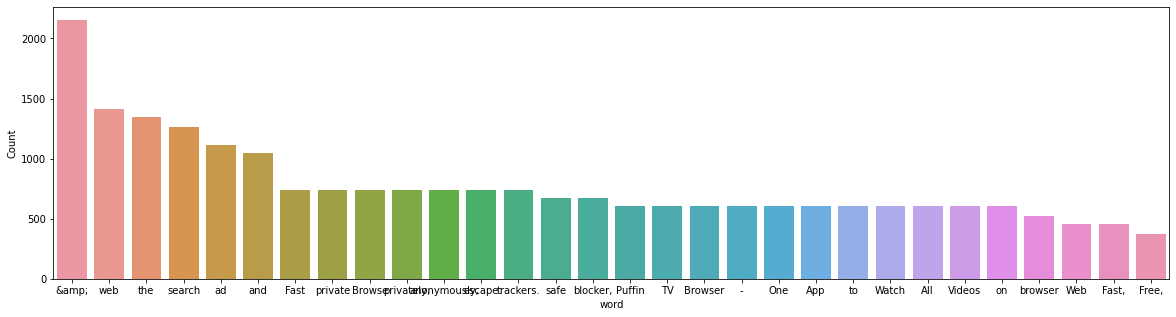

In [9]:
freq_words(data['Short Description'])

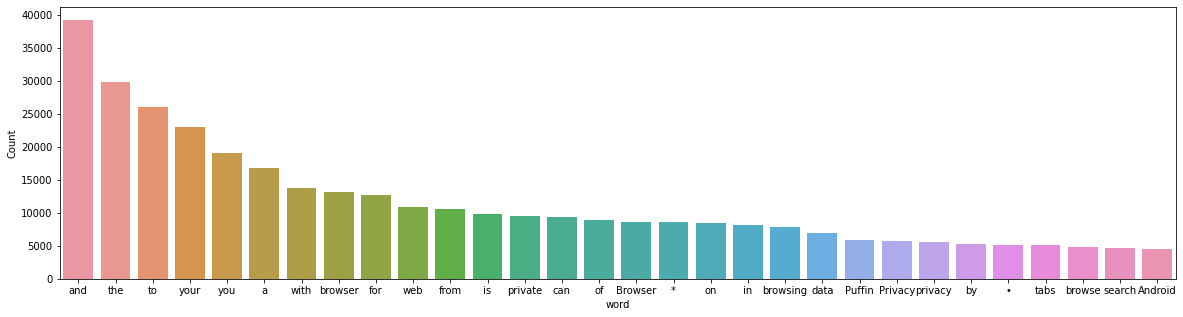

In [10]:
freq_words(data['Long Description'])

### remove unwanted characters, numbers and symbols

In [11]:
data['Short Description'] = data['Short Description'].str.replace("[^a-zA-Z#]", " ")
data['Long Description'] = data['Long Description'].str.replace("[^a-zA-Z#]", " ")

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### function to remove stopwords

In [13]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

### remove short words (length < 3)

In [14]:
data['Short Description'] = data['Short Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
data['Long Description'] = data['Long Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

### remove stopwords from the text and make entire text lowercase

In [15]:
Description_short = [remove_stopwords(r.split()) for r in data['Short Description']]
Description_short = [r.lower() for r in Description_short]

In [16]:
Description_long = [remove_stopwords(r.split()) for r in data['Long Description']]
Description_long = [r.lower() for r in Description_long]

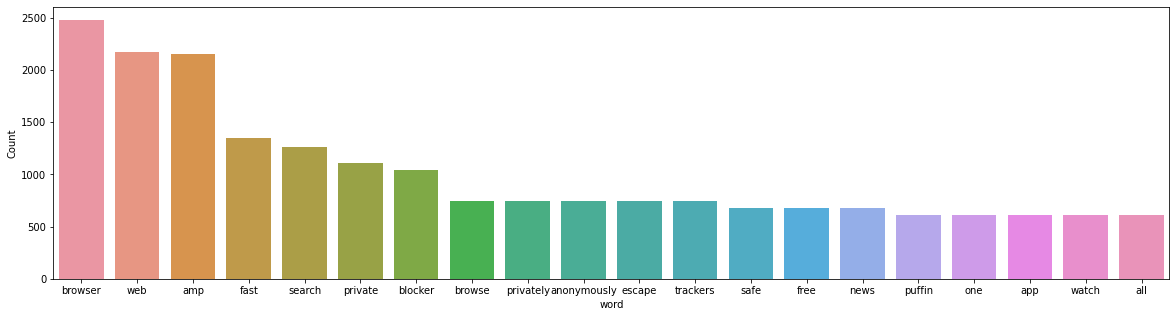

In [20]:
freq_words(Description_short, 20)

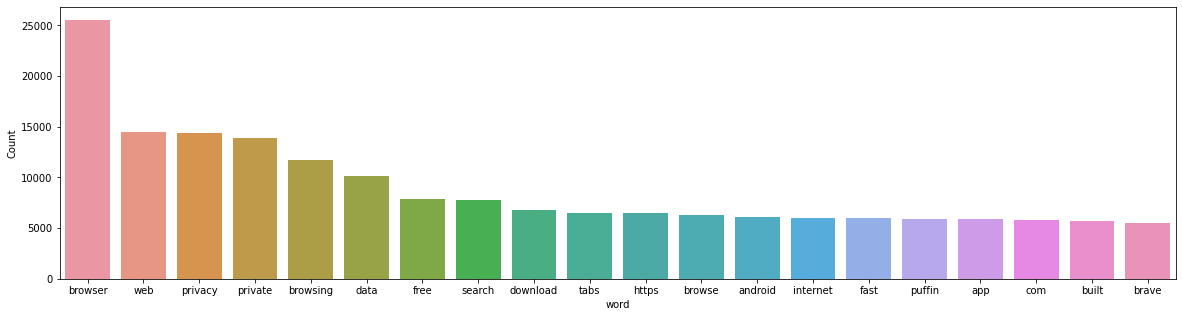

In [21]:
freq_words(Description_long, 20)

### remove noise from the text we can use lemmatization from the spaCy library

In [22]:
nlp = spacy.load('en', disable=['parser', 'ner'])

# filter noun and adjective

def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [23]:
tokenized_short_description = pd.Series(Description_short).apply(lambda x: x.split())
print(tokenized_short_description[1])

['fast', 'simple', 'secure', 'google', 'chrome', 'browser', 'android', 'phones', 'tablets']


In [24]:
tokenized_long_description = pd.Series(Description_long).apply(lambda x: x.split())
print(tokenized_long_description[1])

['google', 'chrome', 'fast', 'easy', 'use', 'secure', 'web', 'browser', 'designed', 'android', 'chrome', 'brings', 'personalized', 'news', 'articles', 'quick', 'links', 'favorite', 'sites', 'downloads', 'google', 'search', 'google', 'translate', 'built', 'download', 'enjoy', 'chrome', 'web', 'browser', 'experience', 'love', 'across', 'devices', 'browse', 'fast', 'type', 'less', 'choose', 'personalized', 'search', 'results', 'instantly', 'appear', 'type', 'quickly', 'browse', 'previously', 'visited', 'web', 'pages', 'fill', 'forms', 'quickly', 'autofill', 'incognito', 'browsing', 'use', 'incognito', 'mode', 'browse', 'internet', 'without', 'saving', 'history', 'browse', 'privately', 'across', 'devices', 'sync', 'chrome', 'across', 'devices', 'when', 'sign', 'chrome', 'bookmarks', 'passwords', 'settings', 'automatically', 'synced', 'across', 'devices', 'you', 'seamlessly', 'access', 'information', 'phone', 'tablet', 'laptop', 'all', 'favorite', 'content', 'one', 'tap', 'away', 'chrome', 

In [25]:
tokenized_short_description_2 = lemmatization(tokenized_short_description)
print(tokenized_short_description_2[1]) # print lemmatized review

['fast', 'simple', 'secure', 'phone', 'tablet']


In [26]:
tokenized_long_description_2 = lemmatization(tokenized_long_description)
print(tokenized_long_description_2[1]) # print lemmati

['easy', 'use', 'secure', 'web', 'browser', 'android', 'chrome', 'personalized', 'news', 'article', 'quick', 'link', 'favorite', 'site', 'download', 'download', 'chrome', 'web', 'browser', 'experience', 'love', 'device', 'fast', 'type', 'personalized', 'search', 'result', 'type', 'web', 'page', 'form', 'internet', 'history', 'browse', 'device', 'chrome', 'device', 'chrome', 'bookmark', 'passwords', 'setting', 'device', 'information', 'phone', 'tablet', 'laptop', 'favorite', 'content', 'tap', 'chrome', 'fast', 'search', 'tap', 'favorite', 'content', 'favorite', 'news', 'site', 'social', 'medium', 'new', 'page', 'chrome', 'search', 'feature', 'webpage', 'word', 'phrase', 'start', 'page', 'protect', 'phone', 'safe', 'browsing', 'chrome', 'safe', 'browsing', 'phone', 'safe', 'warning', 'navigate', 'dangerous', 'site', 'dangerous', 'file', 'download', 'web', 'page', 'video', 'offline', 'chrome', 'dedicated', 'download', 'button', 'video', 'picture', 'entire', 'webpage', 'tap', 'chrome', 'ho

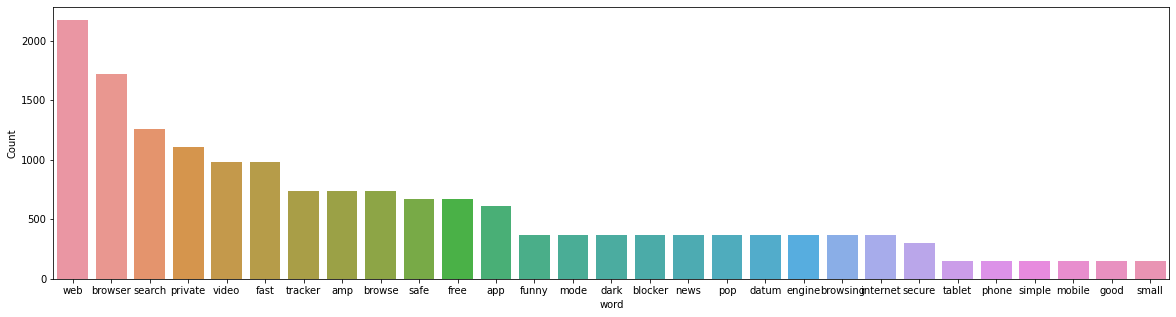

In [29]:
tokenized_short_description_3 = []
for i in range(len(tokenized_short_description_2)):
    tokenized_short_description_3.append(' '.join(tokenized_short_description_2[i]))

data['Description_short'] = tokenized_short_description_3

freq_words(data['Description_short'], 30)

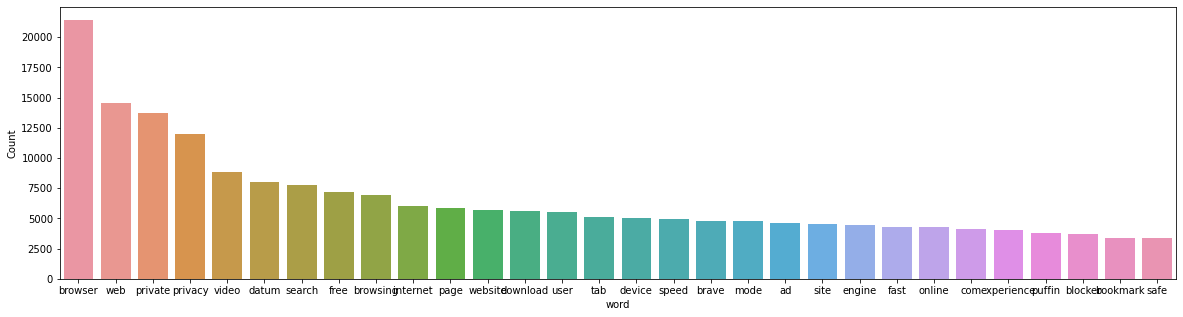

In [30]:
tokenized_long_description_3 = []
for i in range(len(tokenized_long_description_2)):
    tokenized_long_description_3.append(' '.join(tokenized_long_description_2[i]))

data['Description_long'] = tokenized_long_description_3

freq_words(data['Description_long'], 30)

In [33]:
dictionary_short = corpora.Dictionary(tokenized_short_description_2)
dictionary_long = corpora.Dictionary(tokenized_long_description_2)

In [36]:
doc_term_matrix_short = [dictionary_short.doc2bow(rev) for rev in tokenized_short_description_2]
doc_term_matrix_long = [dictionary_long.doc2bow(rev) for rev in tokenized_long_description_2]

### Creating the object for LDA model using gensim library

In [37]:

LDA = gensim.models.ldamodel.LdaModel

In [38]:
# Build LDA model
lda_model_short = LDA(corpus=doc_term_matrix_short, id2word=dictionary_short, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [39]:
lda_model_long = LDA(corpus=doc_term_matrix_long, id2word=dictionary_long, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [40]:
lda_model_short.print_topics()

[(0,
  '0.035*"web" + 0.035*"fast" + 0.035*"browser" + 0.035*"search" + 0.034*"video" + 0.034*"tracker" + 0.034*"browse" + 0.034*"secure" + 0.034*"amp" + 0.034*"private"'),
 (1,
  '0.123*"free" + 0.123*"safe" + 0.123*"browser" + 0.064*"engine" + 0.064*"internet" + 0.064*"browsing" + 0.064*"pop" + 0.064*"blocker" + 0.064*"amp" + 0.064*"search"'),
 (2,
  '0.333*"web" + 0.333*"app" + 0.333*"video" + 0.000*"fast" + 0.000*"browser" + 0.000*"search" + 0.000*"secure" + 0.000*"browse" + 0.000*"tracker" + 0.000*"amp"'),
 (3,
  '0.250*"private" + 0.125*"fast" + 0.125*"web" + 0.125*"amp" + 0.125*"mode" + 0.125*"dark" + 0.125*"browser" + 0.000*"search" + 0.000*"video" + 0.000*"tracker"'),
 (4,
  '0.200*"browser" + 0.200*"video" + 0.200*"news" + 0.200*"funny" + 0.200*"datum" + 0.000*"web" + 0.000*"fast" + 0.000*"search" + 0.000*"tracker" + 0.000*"secure"'),
 (5,
  '0.195*"tracker" + 0.195*"browse" + 0.195*"search" + 0.195*"web" + 0.044*"tablet" + 0.044*"phone" + 0.044*"simple" + 0.044*"secure" + 0.

In [41]:
lda_model_long.print_topics()

[(0,
  '0.046*"opera" + 0.024*"private" + 0.022*"news" + 0.019*"device" + 0.019*"browser" + 0.017*"tab" + 0.017*"experience" + 0.015*"safe" + 0.015*"browsing" + 0.015*"free"'),
 (1,
  '0.002*"browser" + 0.002*"feature" + 0.002*"speed" + 0.002*"datum" + 0.002*"device" + 0.002*"internet" + 0.002*"site" + 0.002*"search" + 0.002*"bookmark" + 0.002*"share"'),
 (2,
  '0.058*"video" + 0.042*"website" + 0.040*"download" + 0.025*"mode" + 0.021*"file" + 0.019*"speed" + 0.019*"datum" + 0.018*"page" + 0.017*"player" + 0.015*"manager"'),
 (3,
  '0.113*"privacy" + 0.048*"datum" + 0.036*"search" + 0.036*"online" + 0.036*"com" + 0.024*"internet" + 0.024*"site" + 0.024*"tracker" + 0.024*"duckduckgo" + 0.024*"tap"'),
 (4,
  '0.077*"browser" + 0.067*"private" + 0.046*"web" + 0.029*"free" + 0.029*"brave" + 0.025*"privacy" + 0.020*"ad" + 0.020*"search" + 0.020*"browsing" + 0.020*"tab"'),
 (5,
  '0.002*"browser" + 0.002*"feature" + 0.002*"speed" + 0.002*"datum" + 0.002*"device" + 0.002*"internet" + 0.002*"s

 ### Visualize the topics - 

In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_short, doc_term_matrix_short, dictionary_short)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.163157 -0.172303       1        1  30.959116
5      0.170146  0.280610       2        1  19.432378
3      0.106568 -0.129658       3        1  17.296353
4     -0.352169 -0.163788       4        1  11.002447
2     -0.256390  0.237086       5        1  10.000906
6      0.113612  0.002590       6        1   9.211817
0      0.055077 -0.054537       7        1   2.096983, topic_info=       Term         Freq        Total Category  logprob  loglift
14    video   969.000000   969.000000  Default  29.0000  29.0000
13      app   589.000000   589.000000  Default  28.0000  28.0000
21  private  1105.000000  1105.000000  Default  27.0000  27.0000
0   browser  1777.000000  1777.000000  Default  26.0000  26.0000
7       web  2106.000000  2106.000000  Default  25.0000  25.0000
..      ...          ...          ...      ...      ...      ...
1      fast    12.534825  1024.362907   Topic7  -3.3660  -0.5386
21  private    12.518488  1105.795155   Topic7  -3.3673  -0.6164
4    search    12.526246  1189.848630   Topic7  -3.3667  -0.6891
0   browser    12.526927  1777.732381   Topic7  -3.3666  -1.0905
7       web    12.544052  2106.744871   Topic7  -3.3652  -1.2590

[232 rows x 6 columns], token_table=      Topic      Freq Term
term                      
15        1  0.471261  amp
15        3  0.510874  amp
15        7  0.017758  amp
13        5  0.977662  app
13        7  0.022065  app
...     ...       ...  ...
7         2  0.310906  web
7         3  0.177525  web
7         5  0.273408  web
7         6  0.084016  web
7         7  0.006171  web

[74 rows x 3 columns], R=29, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 5, 3, 7, 1])

In [43]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_long, doc_term_matrix_long, dictionary_long)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.045773  0.051910       1        1  35.850589
2      0.079196  0.007106       2        1  20.415611
6      0.174898  0.246647       3        1  16.741469
0      0.037173 -0.148399       4        1  13.465957
3     -0.363311  0.062867       5        1  13.339018
5      0.058909 -0.110066       6        1   0.093678
1      0.058909 -0.110066       7        1   0.093678, topic_info=          Term          Freq         Total Category  logprob  loglift
47     privacy  11974.000000  11974.000000  Default  30.0000  30.0000
117      video   8706.000000   8706.000000  Default  29.0000  29.0000
68         web  14519.000000  14519.000000  Default  28.0000  28.0000
253     puffin   3782.000000   3782.000000  Default  27.0000  27.0000
276      brave   4794.000000   4794.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
26        full      1.049483   1500.319728   Topic7  -6.0258  -0.2921
210  available      1.049482   1775.652835   Topic7  -6.0258  -0.4606
249      light      1.049480   1037.932256   Topic7  -6.0258   0.0764
180    private      1.049478  13682.093035   Topic7  -6.0258  -2.5025
134        com      1.049478   4136.498604   Topic7  -6.0258  -1.3063

[455 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.172656   access
0         2  0.396740   access
0         3  0.219493   access
0         4  0.209850   access
0         6  0.000459   access
...     ...       ...      ...
208       6  0.006452     year
208       7  0.006452     year
413       2  0.991884  youtube
413       6  0.002725  youtube
413       7  0.002725  youtube

[1054 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 1, 4, 6, 2])

## Wordcloud 

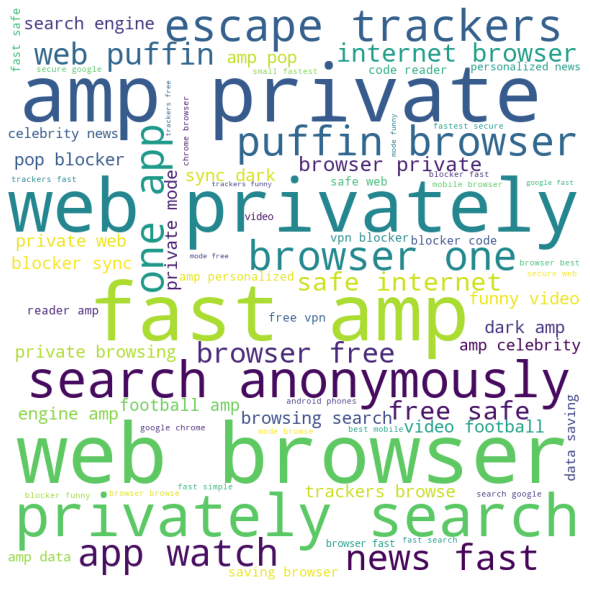

In [44]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in data['Short Description']: 
      
    val = str(val) 
    tokens = val.split() 

    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                     
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

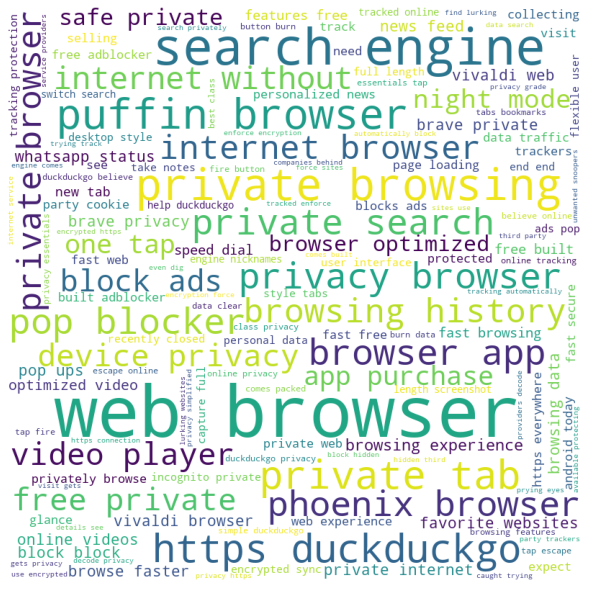

In [45]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in data['Long Description']: 
      
    val = str(val) 
    tokens = val.split() 

    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()